In [2]:
% matplotlib inline

In [71]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics import r2_score
import shapefile
import shapely.geometry as sgeom
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import rgb2hex
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from descartes import PolygonPatch
from shapely.geometry import Polygon

In [4]:
fold_results = []
for i in range(1, 5 + 1):
  fold_data = pd.read_csv("../data/fold_%d/test.csv" % i)
  mu = np.load("../data/fold_%d/mu.npy" % i)
  std = np.load("../data/fold_%d/std.npy" % i)
  true = np.load("./fold_%d/y_true.npy" % i)
  l8 = np.load("./fold_%d/y_pred_l8.npy" % i)
  s1 = np.load("./fold_%d/y_pred_s1.npy" % i)
  
  fold_results.append(pd.DataFrame({
    "true": true * std + mu,
    "l8": l8 * std + mu,
    "s1": s1 * std + mu,
    "pred": np.average((l8 * std + mu, s1 * std + mu), axis=0, weights=[0.5, 0.5]),
    "state_idx": fold_data["state_idx"],
    "district_idx": fold_data["district_idx"],
    "taluk_idx": fold_data["taluk_idx"]
  }))

In [5]:
test_df = pd.concat(fold_results)

(array([4.10000e+01, 3.66000e+02, 8.86600e+03, 5.61220e+04, 1.28763e+05,
        1.21921e+05, 8.04930e+04, 5.12590e+04, 2.85550e+04, 1.55530e+04]),
 array([1.98456699e-02, 2.01785282e+00, 4.01585997e+00, 6.01386712e+00,
        8.01187427e+00, 1.00098814e+01, 1.20078886e+01, 1.40058957e+01,
        1.60039029e+01, 1.80019100e+01, 1.99999172e+01]),
 <a list of 10 Patch objects>)

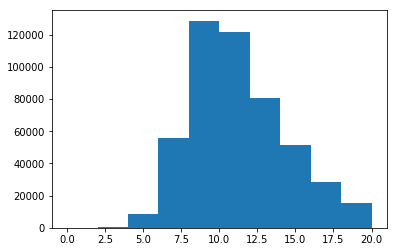

In [160]:
plt.hist((test_df["true"] / 30 / 53.44)[test_df["true"] / 30 / 53.44 < 20])

In [41]:
# https://data.worldbank.org/indicator/PA.NUS.FCRF?end=2016&start=2012
np.mean(test_df["true"] / 53.44 / 30 < 1)

3.52065844136539e-05

In [43]:
r2_score(test_df["true"], test_df["pred"])

0.25793520062326813

In [131]:
r2_score(test_df.groupby("taluk_idx")["true"].mean(), test_df.groupby("taluk_idx")["pred"].mean())

0.5379471843193621

In [130]:
r2_score(test_df.groupby("district_idx")["true"].mean(), test_df.groupby("district_idx")["pred"].mean())

0.6720109175571195

In [145]:
np.max(test_df["taluk_idx"])

2339

In [123]:
district_shapes = shapefile.Reader("../data/india_shape_files/IND_adm2").shapes()
district_points = [shape.points for shape in district_shapes]
district_polygons = [Polygon(p) for p in district_points]

In [140]:
taluk_shapes = shapefile.Reader("../data/india_shape_files/IND_adm3").shapes()
taluk_points = [shape.points for shape in taluk_shapes]
taluk_polygons = [Polygon(p) for p in taluk_points]

In [149]:
taluk_areas = [p.area for p in taluk_polygons]

(array([1105.,  889.,  179.,   90.,   35.,   17.,    6.,    7.,    6.,
           3.]),
 array([2.38651410e-08, 8.80769644e-02, 1.76153905e-01, 2.64230845e-01,
        3.52307786e-01, 4.40384726e-01, 5.28461667e-01, 6.16538607e-01,
        7.04615548e-01, 7.92692488e-01, 8.80769429e-01]),
 <a list of 10 Patch objects>)

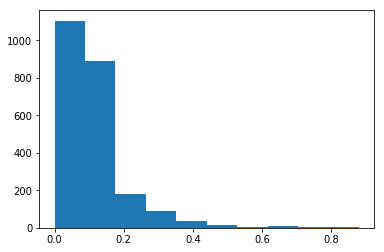

In [159]:
plt.hist(np.array(taluk_areas)[np.array(taluk_areas) < 1])

In [156]:
idx_to_values = test_df.groupby("taluk_idx")["pred"].mean()
division_polygons = taluk_polygons

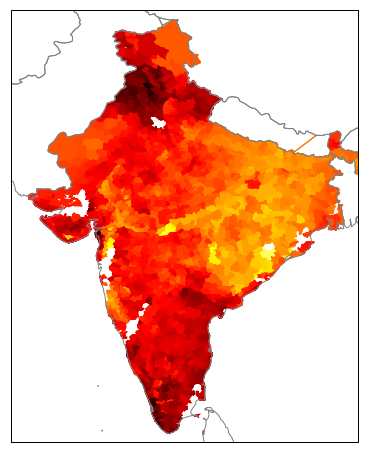

In [158]:
fig = plt.figure(figsize=(12, 6))

ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax.set_extent([67, 90, 7.5, 36])

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none')

cmap = plt.cm.hot
vmin = np.min(idx_to_values)
vmax = np.max(idx_to_values) 

for i, polygon in enumerate(division_polygons):
  if i in idx_to_values:
    color = rgb2hex(cmap(1-np.sqrt((idx_to_values[i]-vmin)/(vmax-vmin))))
    poly = PolygonPatch(polygon, facecolor=color, edgecolor=color)
    ax.add_patch(poly)

ax.add_feature(states_provinces, edgecolor='gray')